In [54]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision

from id_selector import IDSelector
import dataset
import unet
import dl_stats

### generate ID list

In [2]:
class_ids = IDSelector(
    main_path='/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/',
    start_year=2004,
    end_year=2019,
    month_only=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    year_only=None,
    mcs_only=True,
    percent_train=0.7,
    percent_validate=0.1,
)

# here we generate the list of IDs by loading from a presaved dictionary
IDlist = class_ids.generate_IDarray(dict_freq='1H')

# here we shuffle and split the IDs into a testing and training set
train_IDs, valid_IDs, test_IDs = class_ids.generate_traintest_split(
    IDlist,
    seed=0,
)

starting ID generation...
ID generation complete.


In [4]:
print(
    f"Training set contains {len(train_IDs)} total training MCSs."
)
print(
    f"Validation set contains {len(valid_IDs)} total training MCSs."
)
print(
    f"Testing set contains {len(test_IDs)} total training MCSs."
)

Training set contains 48747 total training MCSs.
Validation set contains 8124 total training MCSs.
Testing set contains 24375 total training MCSs.


### initiate training, validation, and testing data

In [5]:
variables = ["ttr"]

In [6]:
training_generator = dataset.CustomDataset(
    list_IDs=train_IDs,
    path_dataID=f"/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/dl_files/1H/",
    variable=variables,
    batch_size=32,
    dim=(121, 321),
    n_channels=len(variables),
    n_classes=2,
    shuffle=True,
    norm='zscore',
    transform=torchvision.transforms.RandomVerticalFlip(p=0.5),
)
train_load = DataLoader(
    training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

In [7]:
#for data in train_load:
#    print(data['test'].squeeze().size())
#    break

In [8]:
#plt.imshow(data['train'].squeeze()[0,:,:]); plt.show()
#plt.imshow(data['test'].squeeze()[0,1,:,:], cmap="Reds", vmin=0, vmax=1); plt.show()

In [9]:
validating_generator = dataset.CustomDataset(
    list_IDs=valid_IDs,
    path_dataID=f"/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/dl_files/1H/",
    variable=variables,
    batch_size=32,
    dim=(121, 321),
    n_channels=len(variables),
    n_classes=2,
    shuffle=True,
    norm='zscore',
    transform=torchvision.transforms.RandomVerticalFlip(p=0.5),
)
valid_load = DataLoader(
    validating_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

In [10]:
testing_generator = dataset.CustomDataset(
    list_IDs=test_IDs,
    path_dataID=f"/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/dl_files/1H/",
    variable=variables,
    batch_size=1,
    dim=(121, 321),
    n_channels=len(variables),
    n_classes=2,
    shuffle=False,
    norm='zscore',
)
test_load = DataLoader(
    testing_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

### training functions

In [10]:
def train(model, dataloader, weights=None):
    """
    Training function.

    Args:
        model (torch): pytorch neural network.
        dataloader (torch): pytorch dataloader.
        weights (boolean): weights for custom loss.

    """
    model.train()

    running_loss = 0.0
    corrcoef_loss = 0.0

    for data in dataloader:

        img_noisy = data['train'].squeeze(dim=0)
        img_noisy = img_noisy.to(device)

        img_label = data['test'].squeeze(dim=0)
        
        target = img_label.cpu()[:,1,:,:].squeeze() #crosssentropy
        target = target.to(device)

        img_label = img_label.to(device)  #IoU

        outputs = model(img_noisy.float())
        
        try:
            if not weights:
                loss = criterion(outputs, target.long()) #crosssentropy
        except ValueError:
            loss = criterion(outputs, target.long(), weights)

        closs = secondcrt(outputs, img_label.float())

        optimizer.zero_grad()   # back prop
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        corrcoef_loss += closs.item()

    train_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)

    return train_loss, coef_loss

In [11]:
def validate(model, dataloader, weights=None):
    """
    Validation function.

    Args:
        model: pytorch neural network.
        dataloader: pytorch dataloader.
        weights (boolean): weights for custom loss.

    """
    model.eval()

    running_loss = 0.0
    corrcoef_loss = 0.0

    with torch.no_grad():

        for i, data in enumerate(dataloader):

            img_noisy = data['train'].squeeze(dim=0)
            img_noisy = img_noisy.to(device)

            img_label = data['test'].squeeze(0)
            
            target = img_label.cpu()[:,1,:,:].squeeze() #crosssentropy
            target = target.to(device)
            
            img_label = img_label.to(device)  #IoU

            outputs = model(img_noisy.float())
            
            try:
                if not weights:
                    loss = criterion(outputs, target.long()) #crosssentropy
            except ValueError:
                loss = criterion(outputs, target.long(), weights)

            closs = secondcrt(outputs, img_label.float())

            running_loss += loss.item()
            corrcoef_loss += closs.item()

    val_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)

    return val_loss, coef_loss

### initiate unet for training

In [12]:
net = unet.UNet(n_channels=len(variables), n_classes=2)

In [13]:
LEARNING_RATE = 1e-4

# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, amsgrad=False)

# the loss function
# criterion = nn.MSELoss(reduction='sum')
criterion = nn.CrossEntropyLoss()
secondcrt = unet.IoULoss()

In [14]:
device = unet.get_device()
print(device)
net.to(device)

cuda:0


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [15]:
NUM_EPOCHS = 20
train_loss = []
valid_loss = []
train_corr = []
valid_corr = []

for enum, epoch in enumerate(range(NUM_EPOCHS)):

    t_loss, t_corr = train(net, train_load, weights=None)
    v_loss, v_corr = validate(net, valid_load, weights=None)

    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    train_corr.append(t_corr)
    valid_corr.append(v_corr)

    print(
        f"Epoch {epoch + 1} of {NUM_EPOCHS}; Train Loss: {t_loss:.4f}, Train IoU: {t_corr:.4f}; Val Loss: {v_loss:.4f}, Val IoU: {v_corr:.4f}"
    )

Epoch 1 of 20; Train Loss: 0.1219, Train IoU: 0.3514; Val Loss: 0.0472, Val IoU: 0.2206
Epoch 2 of 20; Train Loss: 0.0362, Train IoU: 0.1704; Val Loss: 0.0340, Val IoU: 0.1333
Epoch 3 of 20; Train Loss: 0.0308, Train IoU: 0.1165; Val Loss: 0.0303, Val IoU: 0.1014
Epoch 4 of 20; Train Loss: 0.0291, Train IoU: 0.0913; Val Loss: 0.0314, Val IoU: 0.0810
Epoch 5 of 20; Train Loss: 0.0280, Train IoU: 0.0770; Val Loss: 0.0283, Val IoU: 0.0715
Epoch 6 of 20; Train Loss: 0.0270, Train IoU: 0.0680; Val Loss: 0.0277, Val IoU: 0.0638
Epoch 7 of 20; Train Loss: 0.0260, Train IoU: 0.0617; Val Loss: 0.0271, Val IoU: 0.0582
Epoch 8 of 20; Train Loss: 0.0250, Train IoU: 0.0570; Val Loss: 0.0261, Val IoU: 0.0536
Epoch 9 of 20; Train Loss: 0.0242, Train IoU: 0.0535; Val Loss: 0.0252, Val IoU: 0.0524
Epoch 10 of 20; Train Loss: 0.0233, Train IoU: 0.0506; Val Loss: 0.0254, Val IoU: 0.0479
Epoch 11 of 20; Train Loss: 0.0224, Train IoU: 0.0482; Val Loss: 0.0252, Val IoU: 0.0464
Epoch 12 of 20; Train Loss: 0.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/glade/work/molina/miniconda3/envs/myenv-tfgpu/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 199, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/glade/work/molina/miniconda3/envs/myenv-tfgpu/lib/python3.8/site-packages/xarray/backends/lru_cache.py", line 53, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/dl_files/1H/ttr/file_ttr_ID83577.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/glade/work/molina/miniconda3/envs/myenv-tfgpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/glade/derecho/scratch/molina/tmp/ipykernel_70361/3874238370.py", line 9,

TypeError: object of type 'NoneType' has no len()

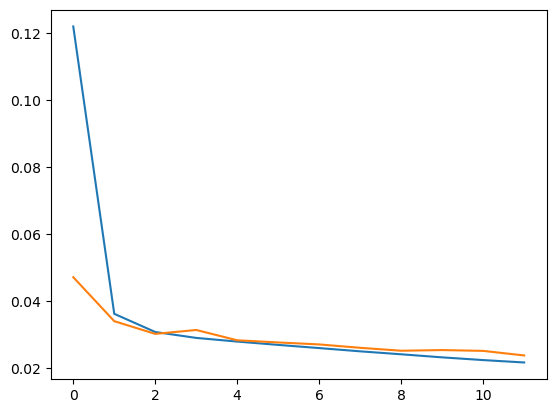

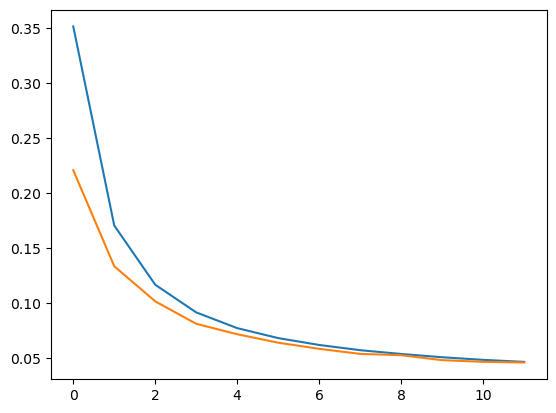

In [16]:
plt.plot(train_loss[:]);
plt.plot(valid_loss[:]);
plt.show()

plt.plot(train_corr[:]);
plt.plot(valid_corr[:]);
plt.show()

In [17]:
torch.save(
    net.state_dict(),
    '/glade/derecho/scratch/molina/mcs_unet_model_1channel.pt'
)

# Load saved model and inference

In [12]:
net = unet.UNet(n_channels=len(variables), n_classes=2)
net.load_state_dict(
    torch.load('/glade/derecho/scratch/molina/mcs_unet_model_1channel.pt',
              map_location=torch.device('cpu'))
)
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

### evaluation

In [16]:
device = unet.get_device()

In [17]:
def generate_predictions(model, IDs, torch_dataset, torch_dataloader, num_classes=2, softmax=False):

    shape_0 = IDs.shape[0]
    shape_1 = torch_dataset.__getitem__(0)['train'].squeeze(dim=0).shape[1]
    shape_2 = torch_dataset.__getitem__(0)['train'].squeeze(dim=0).shape[2]

    predictions_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    pred_labels_ = np.zeros((shape_0, num_classes, shape_1, shape_2))

    indx_ = []
    model.eval()
    count_ = 0

    if softmax:
        m = nn.Softmax(dim=1)

    with torch.no_grad():

        for i, data in enumerate(torch_dataloader):

            img_noisy = data['train'].squeeze(dim=0)
            img_noisy = img_noisy.to(device)
            img_label = data['test'].squeeze(dim=0)
            img_label = img_label.to(device)
            indx_.append(data['minibatch_indx'])

            outputs = model(img_noisy.float())

            if softmax:
                outputs = m(outputs)

            for out_ in range(outputs.shape[0]):

                predictions_[count_, ...] = outputs.cpu()[out_, ...]
                pred_labels_[count_, ...] = img_label.cpu()[out_, ...]

                count_ += 1

            if i == 99:
                break

    indx_ = np.array([ind for i in indx_ for ind in i.numpy()])

    return predictions_.astype(np.float32), pred_labels_.astype(np.float32), indx_

In [18]:
predictions_, pred_labels_, indx_ = generate_predictions(
    net,
    test_IDs[:100],
    testing_generator,
    test_load,
    softmax=True
)

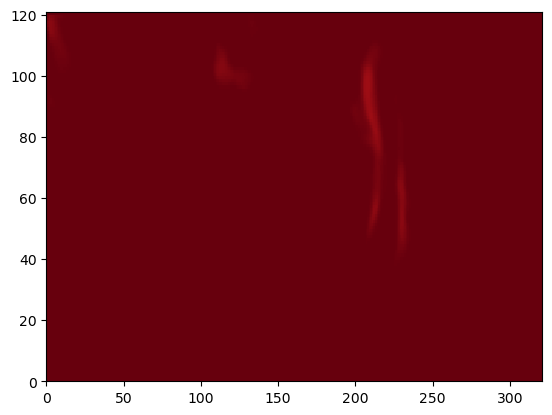

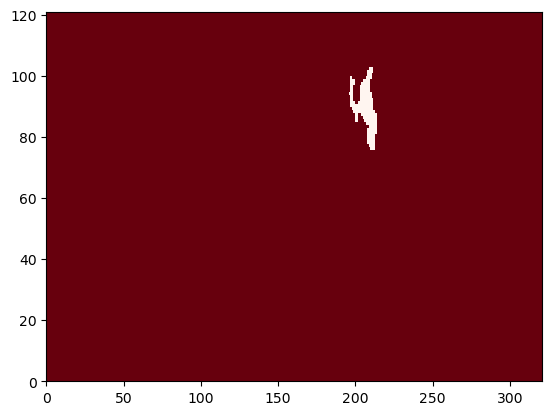

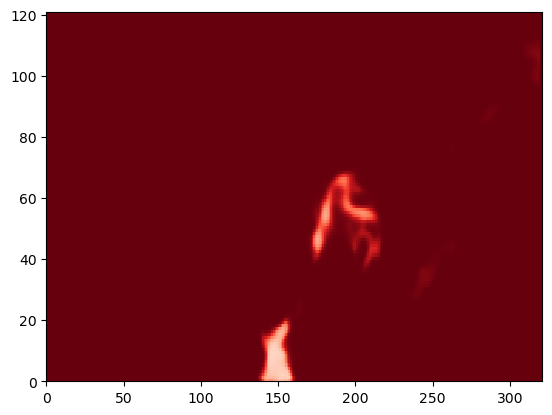

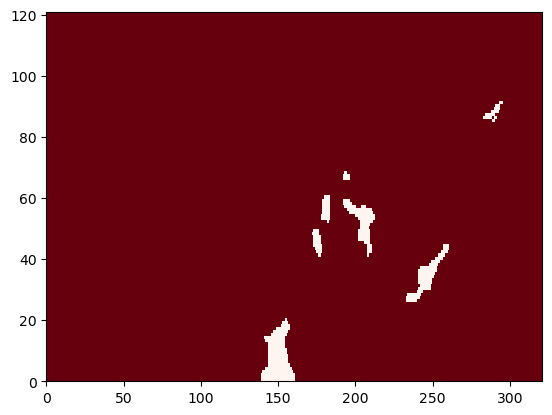

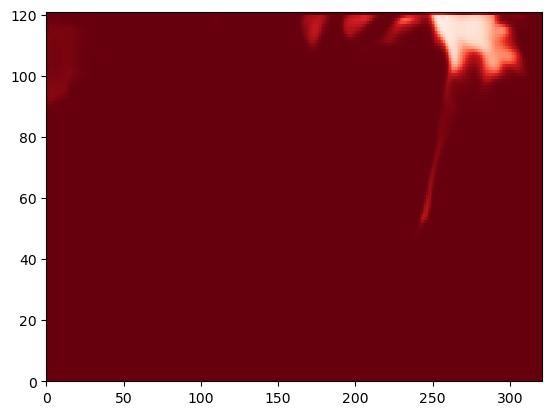

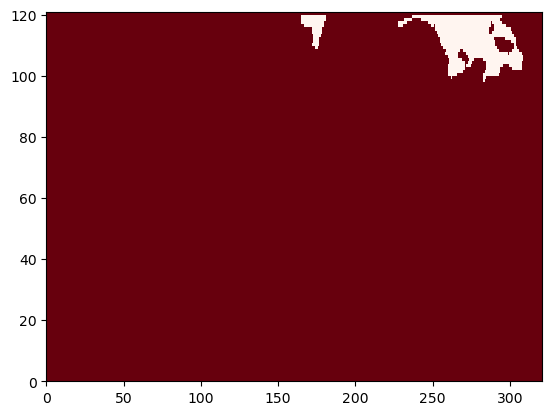

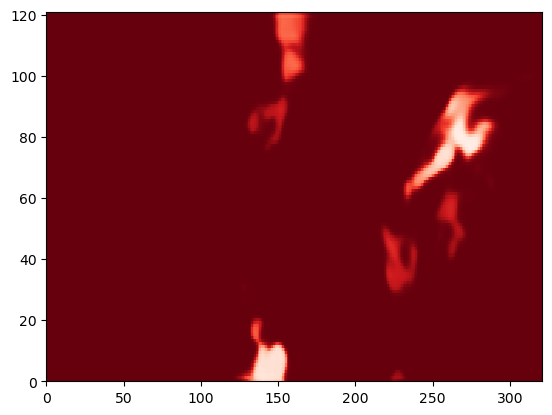

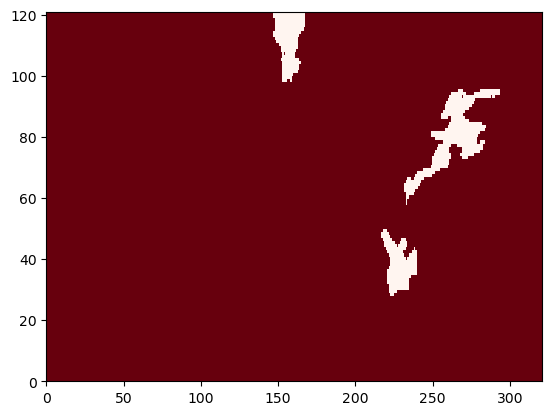

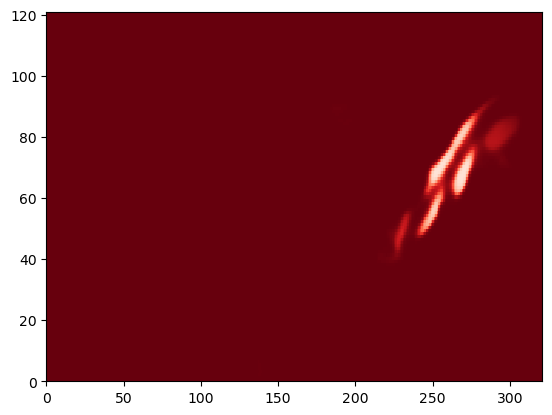

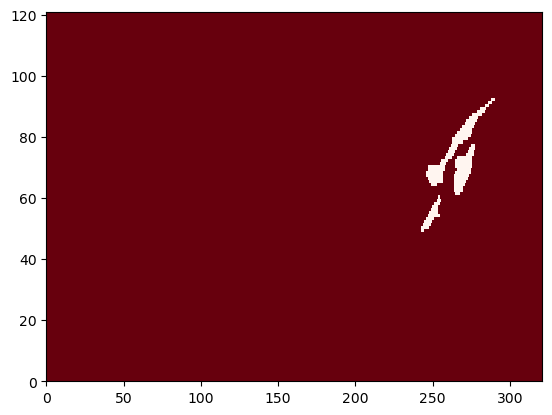

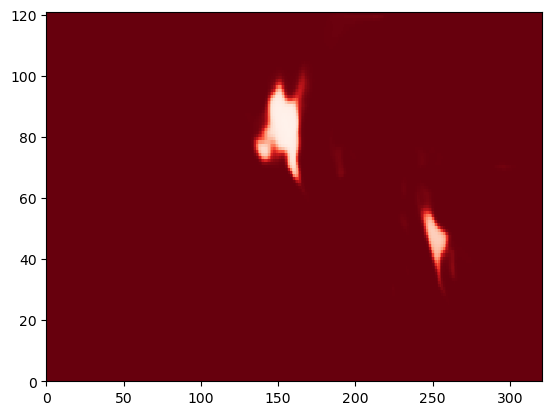

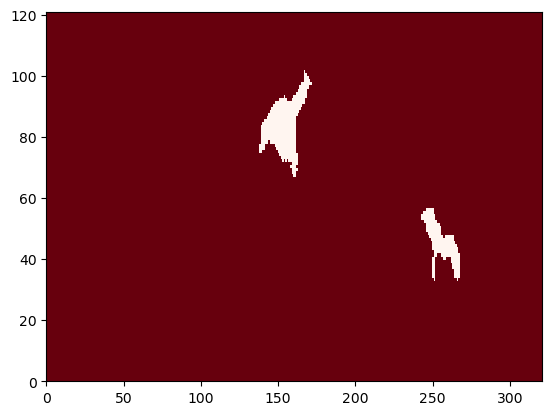

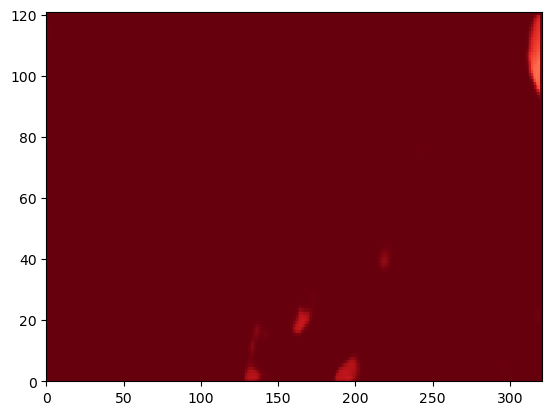

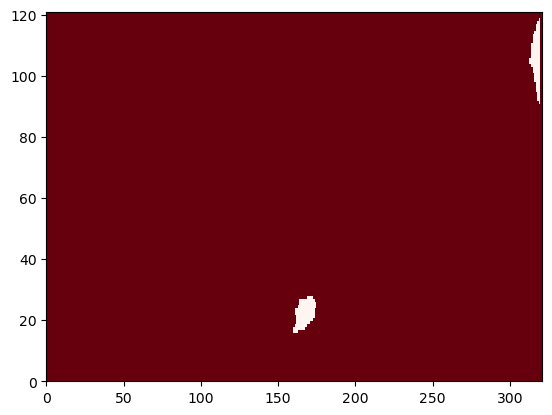

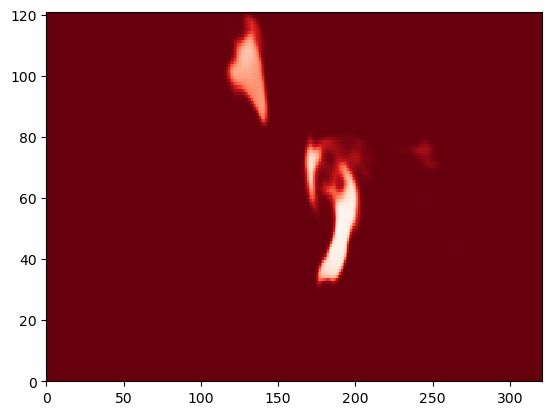

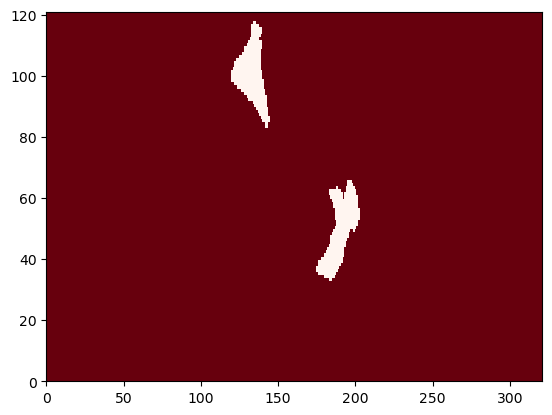

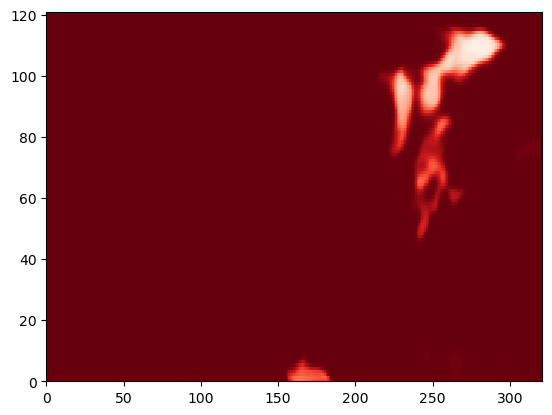

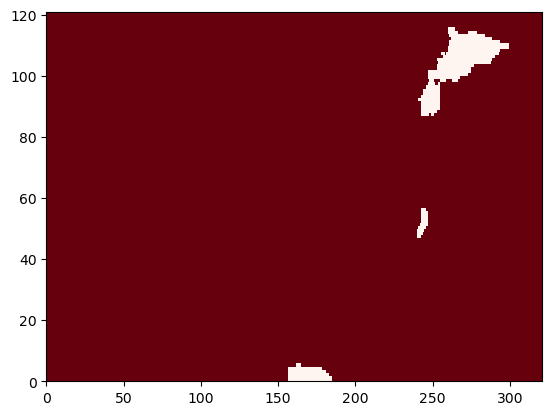

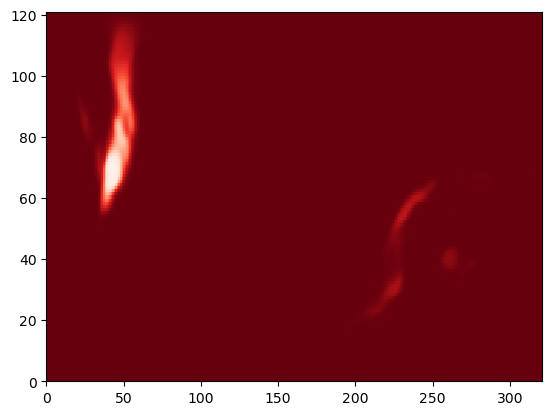

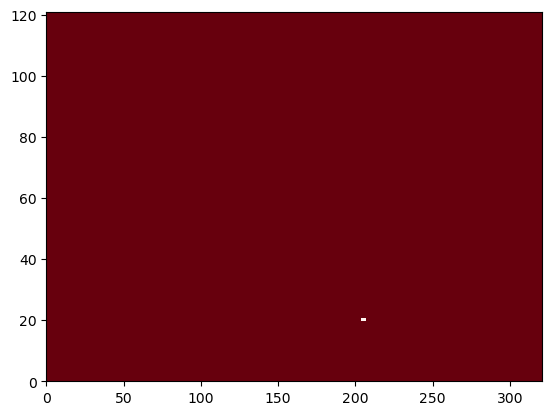

In [20]:
for i in range(0, 10):

    indx=i
    
    plt.pcolormesh(
        predictions_[indx, 0, :, :],
        vmin=0,
        vmax=1,
        cmap='Reds'
    ); plt.show()
    
    plt.pcolormesh(
        pred_labels_[indx, 0, :, :],
        vmin=0,
        vmax=1,
        cmap='Reds'
    ); plt.show()